## 基础的模型：广义帕累托分布。对于99分位数以后使用重采样的结果。基本可以得到fair fit以上

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
import scanpy as sc
import scipy.sparse as sp
# 读取数据
adata = sc.read("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151676.h5ad")

if sp.issparse(adata.X):
    adata.X = adata.X.A
# 计算每个基因的方差（适用于普通numpy数组）
def calc_var(X, axis=0):
    # 直接使用numpy的var函数
    return np.var(X, axis=axis)

gene_variances = calc_var(adata.X)

# 设定阈值，例如使用98百分位数
threshold = np.percentile(gene_variances, 99)

# 分割数据
main_data = gene_variances[gene_variances <= threshold]
tail_data = gene_variances[gene_variances > threshold]

# 对主体部分拟合广义帕累托分布
shape, loc, scale = genpareto.fit(main_data)

# 生成新样本
n_main = len(main_data)
n_tail = len(tail_data)

# 对主体部分使用拟合的分布生成样本
new_main = genpareto.rvs(shape, loc, scale, size=n_main)

# 对尾部直接进行重抽样
new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

# 合并样本
new_samples = np.concatenate([new_main, new_tail])

# 确保新样本在原始数据的范围内
new_samples = np.clip(new_samples, np.min(gene_variances), np.max(gene_variances))


## 对长尾高值部分的，直接等值。基本可以得到excellent fit的结果

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
import scanpy as sc
import scipy.sparse as sp
# 读取数据
adata = sc.read("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151676.h5ad")

if sp.issparse(adata.X):
    adata.X = adata.X.A
# 计算每个基因的方差（适用于普通numpy数组）
def calc_var(X, axis=0):
    # 直接使用numpy的var函数
    return np.var(X, axis=axis)

gene_variances = calc_var(adata.X)

# 设定阈值，例如使用98百分位数
threshold = np.percentile(gene_variances, 99)

# 分割数据
main_data = gene_variances[gene_variances <= threshold]
tail_data = gene_variances[gene_variances > threshold]

# 对主体部分拟合广义帕累托分布
shape, loc, scale = genpareto.fit(main_data)

# 生成新样本
n_main = len(main_data)
n_tail = len(tail_data)

# 对主体部分使用拟合的分布生成样本
new_main = genpareto.rvs(shape, loc, scale, size=n_main)

# 对尾部直接进行重抽样
new_tail = tail_data
# 合并样本
new_samples = np.concatenate([new_main, new_tail])

# 确保新样本在原始数据的范围内
new_samples = np.clip(new_samples, np.min(gene_variances), np.max(gene_variances))


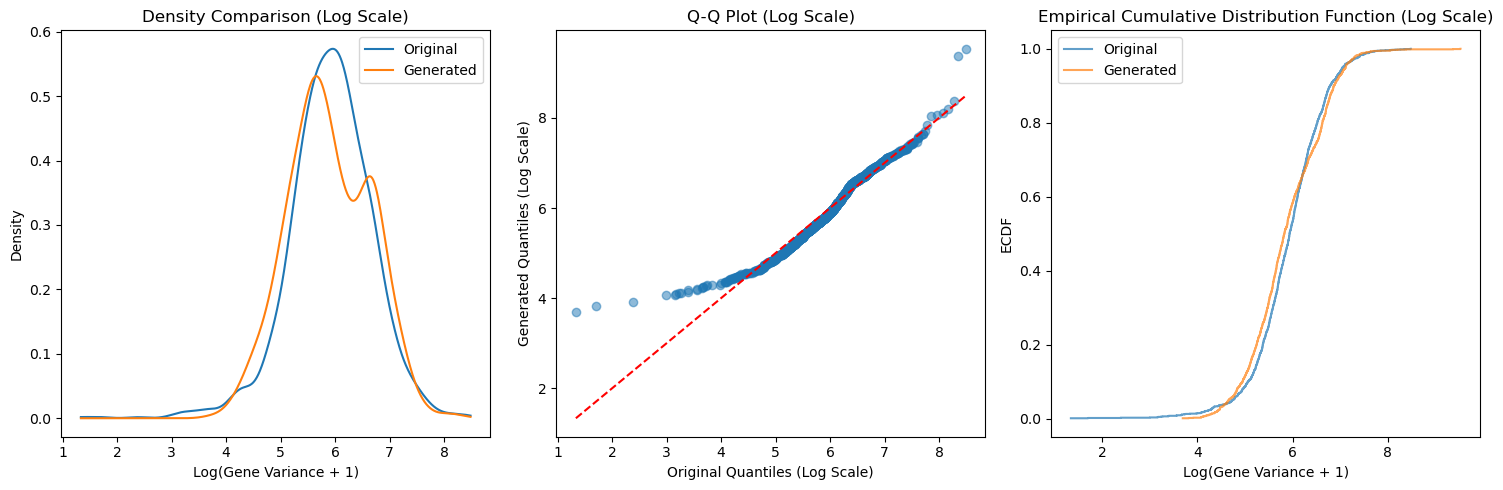

Cohen's d: -0.023227630274917126
Relative Error: 0.025269190893894768
KS Statistic: 0.07602339181286549
Correlation: 0.8843254434434775
Quantile Relative Errors:
  25.0th: 0.1302
  50.0th: 0.1017
  75.0th: 0.1290
  90.0th: 0.0824
  95.0th: 0.0656
  99.0th: 0.0627
Verdict: Fair fit


In [54]:
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def evaluate_fit(original, generated, quantiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]):
    def cohens_d(x1, x2):
        n1, n2 = len(x1), len(x2)
        var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
        pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        return (np.mean(x1) - np.mean(x2)) / pooled_se

    def relative_error(x1, x2):
        return np.abs(np.mean(x1) - np.mean(x2)) / np.mean(x1)

    # 计算主要指标
    effect_size = cohens_d(original, generated)
    rel_error = relative_error(original, generated)
    ks_stat, _ = ks_2samp(original, generated)
    correlation = np.corrcoef(np.sort(original), np.sort(generated))[0, 1]

    # 计算分位数相对误差
    orig_quant = np.quantile(original, quantiles)
    gen_quant = np.quantile(generated, quantiles)
    quant_rel_errors = np.abs(orig_quant - gen_quant) / orig_quant

    # 评估结果
    results = {
        "Cohen's d": effect_size,
        "Relative Error": rel_error,
        "KS Statistic": ks_stat,
        "Correlation": correlation,
        "Quantile Relative Errors": dict(zip([f"{q*100}th" for q in quantiles], quant_rel_errors))
    }

    # 修改判定标准
    excellent = (abs(effect_size) < 0.05 and rel_error < 0.05 and ks_stat < 0.1 and correlation > 0.95
                )

    good = (abs(effect_size) < 0.1 and rel_error < 0.1 and ks_stat < 0.15 and correlation > 0.9 
            )

    fair = (abs(effect_size) < 0.2 and rel_error < 0.15 and ks_stat < 0.2 and correlation > 0.8 
            )



    if excellent:
        verdict = "Excellent fit"
    elif good:
        verdict = "Good fit"
    elif fair:
        verdict = "Fair fit"
    else:
        verdict = "Poor fit"

    results["Verdict"] = verdict

    # 可视化（使用对数刻度）
    plt.figure(figsize=(15, 5))

    # 密度图比较
    plt.subplot(131)
    kde_orig = gaussian_kde(np.log1p(original))
    kde_gen = gaussian_kde(np.log1p(generated))
    x_range = np.linspace(np.min(np.log1p(original)), np.max(np.log1p(original)), 1000)
    plt.plot(x_range, kde_orig(x_range), label='Original')
    plt.plot(x_range, kde_gen(x_range), label='Generated')
    plt.title('Density Comparison (Log Scale)')
    plt.xlabel('Log(Gene Variance + 1)')
    plt.ylabel('Density')
    plt.legend()

    # Q-Q图（对数刻度）
    plt.subplot(132)
    plt.scatter(np.log1p(np.sort(original)), np.log1p(np.sort(generated)), alpha=0.5)
    plt.plot([np.log1p(min(original)), np.log1p(max(original))], 
             [np.log1p(min(original)), np.log1p(max(original))], 'r--')
    plt.xlabel('Original Quantiles (Log Scale)')
    plt.ylabel('Generated Quantiles (Log Scale)')
    plt.title('Q-Q Plot (Log Scale)')

    # ECDF（对数刻度）
    plt.subplot(133)
    def ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(data)+1) / len(data)
        return x, y
    x_orig, y_orig = ecdf(original)
    x_gen, y_gen = ecdf(generated)
    plt.step(np.log1p(x_orig), y_orig, where='post', label='Original', alpha=0.7)
    plt.step(np.log1p(x_gen), y_gen, where='post', label='Generated', alpha=0.7)
    plt.xlabel('Log(Gene Variance + 1)')
    plt.ylabel('ECDF')
    plt.title('Empirical Cumulative Distribution Function (Log Scale)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results

# 使用函数
evaluation = evaluate_fit(gene_variances, new_samples)

# 打印结果
for key, value in evaluation.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue:.4f}")
    else:
        print(f"{key}: {value}")

## 第二个特殊的混合模型：对数正态分布+广义帕累托分布
比如Merfish等，并没有很多dropout的结果，不能直接用广义帕累托分布进行拟合。

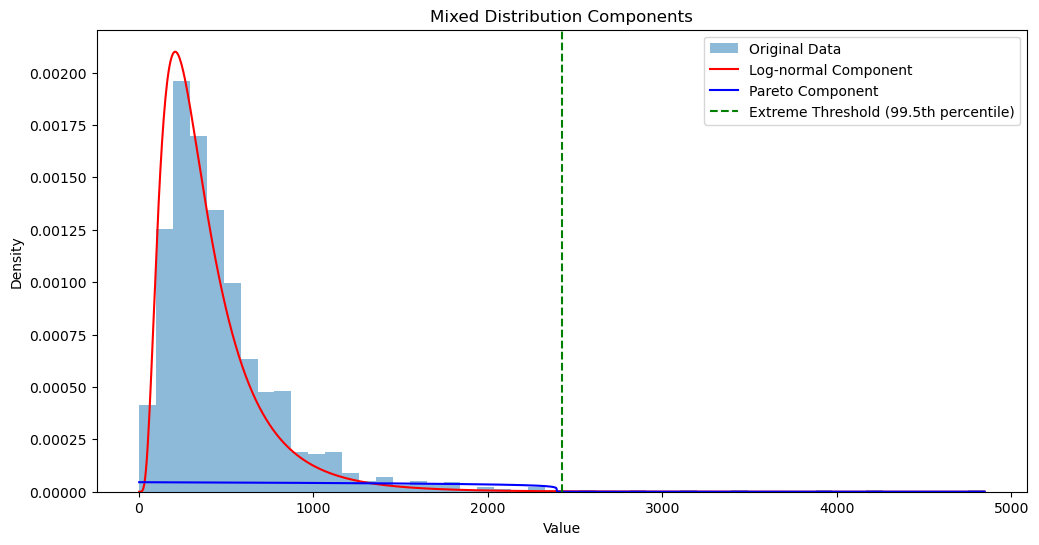

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto, lognorm
from scipy.optimize import minimize
import scanpy as sc
import scipy.sparse as sp

def calc_var(X, axis=0):
    return np.var(X, axis=axis)

def find_threshold_likelihood(data, start_percentile=85, end_percentile=99):
    """使用较高的百分位数范围来寻找帕累托分布的起始点"""
    percentiles = np.arange(start_percentile, end_percentile)
    thresholds = np.percentile(data, percentiles)
    max_likelihood = -np.inf
    optimal_threshold = None
    optimal_params = None
    
    for threshold in thresholds:
        main_data = data[data <= threshold]
        tail_data = data[data > threshold]
        
        if len(main_data) < 10 or len(tail_data) < 10:
            continue
            
        # 计算对数正态分布的对数似然
        log_main = np.log(main_data)
        mu = np.mean(log_main)
        sigma = np.std(log_main)
        lognorm_ll = np.sum(lognorm.logpdf(main_data, s=sigma, scale=np.exp(mu)))
        
        # 计算帕累托分布的对数似然，并检查递减性
        try:
            # Initial fit to the tail
            shape, loc, scale = genpareto.fit(tail_data)
            
            # Ensure Pareto PDF at the threshold is not greater than log-normal PDF
            pareto_pdf_at_threshold = genpareto.pdf(threshold, shape, loc=loc, scale=scale)
            lognorm_pdf_at_threshold = lognorm.pdf(threshold, s=sigma, scale=np.exp(mu))
            
            if pareto_pdf_at_threshold > lognorm_pdf_at_threshold:
                continue  # Skip this threshold if it creates an increasing PDF
            
            pareto_ll = np.sum(genpareto.logpdf(tail_data, shape, loc=loc, scale=scale))
            
            # 添加平滑过渡的惩罚项
            density_diff = abs(lognorm_pdf_at_threshold - pareto_pdf_at_threshold)
            transition_penalty = -density_diff * 100  # 惩罚因子可以调整
            
            total_ll = lognorm_ll + pareto_ll + transition_penalty
            
            if total_ll > max_likelihood:
                max_likelihood = total_ll
                optimal_threshold = threshold
                optimal_params = {
                    'lognorm': (sigma, 0, np.exp(mu)),
                    'pareto': (shape, loc, scale)
                }
                
        except:
            continue
    
    if optimal_threshold is None:
        optimal_threshold = np.percentile(data, 90)
        
    return optimal_threshold, optimal_params

def fit_mixed_distribution(data):
    # 使用似然比方法找到最优分割点
    threshold, optimal_params = find_threshold_likelihood(data)
    
    # 处理极高值
    extreme_threshold = np.percentile(data, 99.5)
    extreme_data = data[data > extreme_threshold]
    
    main_data = data[data <= threshold]
    tail_data = data[(data > threshold) & (data <= extreme_threshold)]
    
    # 使用最优参数
    if optimal_params is not None:
        sigma, loc, scale = optimal_params['lognorm']
        shape, loc_p, scale_p = optimal_params['pareto']
    else:
        # 如果没有找到最优参数，重新拟合
        log_data = np.log(main_data)
        mu = np.mean(log_data)
        sigma = np.std(log_data)
        shape, loc_p, scale_p = genpareto.fit(tail_data)
        scale = np.exp(mu)
        loc = 0
    
    # 计算混合权重
    weight_lognorm = len(main_data) / len(data)
    weight_pareto = len(tail_data) / len(data)
    weight_extreme = len(extreme_data) / len(data)
    
    return {
        'lognorm_params': (sigma, loc, scale),
        'pareto_params': (shape, loc_p, scale_p),
        'weights': (weight_lognorm, weight_pareto, weight_extreme),
        'threshold': threshold,
        'extreme_threshold': extreme_threshold,
        'extreme_data': extreme_data
    }

def generate_mixed_samples(params, n_samples):
    weight_lognorm, weight_pareto, weight_extreme = params['weights']
    n_lognorm = int(n_samples * weight_lognorm)
    n_pareto = int(n_samples * weight_pareto)
    n_extreme = n_samples - n_lognorm - n_pareto
    
    # 生成对数正态分布样本
    sigma, loc, scale = params['lognorm_params']
    lognorm_samples = lognorm.rvs(s=sigma, loc=loc, scale=scale, size=n_lognorm)
    
    # 生成帕累托分布样本，并进行截断
    shape, loc, scale = params['pareto_params']
    threshold = params['threshold']
    
    # 使用接受-拒绝采样来生成截断的帕累托样本
    pareto_samples = []
    max_density = genpareto.pdf(threshold, shape, loc=loc, scale=scale)
    
    while len(pareto_samples) < n_pareto:
        candidates = genpareto.rvs(shape, loc=loc, scale=scale, size=n_pareto)
        densities = genpareto.pdf(candidates, shape, loc=loc, scale=scale)
        accept_prob = densities / max_density
        accept = np.random.random(n_pareto) < accept_prob
        
        valid_samples = candidates[accept]
        pareto_samples.extend(valid_samples[:n_pareto - len(pareto_samples)])
    
    pareto_samples = np.array(pareto_samples[:n_pareto])
    
    # 直接重采样极高值
    extreme_samples = np.random.choice(params['extreme_data'], size=n_extreme, replace=True)
    
    # 合并样本并确保所有值都是正的
    mixed_samples = np.concatenate([lognorm_samples, pareto_samples, extreme_samples])
    mixed_samples = np.maximum(mixed_samples, 0)
    np.random.shuffle(mixed_samples)
    
    return mixed_samples

def plot_distribution_components(data, params):
    """可视化混合分布的组件"""
    plt.figure(figsize=(12, 6))
    
    # 绘制原始数据直方图
    plt.hist(data, bins=50, density=True, alpha=0.5, label='Original Data')
    
    # 生成用于绘制的x值
    x = np.linspace(min(data), max(data), 1000)
    
    # 绘制对数正态分布组件
    sigma, loc, scale = params['lognorm_params']
    weight_lognorm = params['weights'][0]
    y_lognorm = weight_lognorm * lognorm.pdf(x, s=sigma, scale=scale)
    plt.plot(x, y_lognorm, 'r-', label='Log-normal Component')
    
    # 绘制帕累托分布组件
    shape, loc, scale = params['pareto_params']
    weight_pareto = params['weights'][1]
    y_pareto = weight_pareto * genpareto.pdf(x, shape, loc=loc, scale=scale)
    plt.plot(x, y_pareto, 'b-', label='Pareto Component')
    
    # 在极高值范围内添加标记
    extreme_threshold = params['extreme_threshold']
    plt.axvline(extreme_threshold, color='g', linestyle='--', label='Extreme Threshold (99.5th percentile)')
    
    plt.legend()
    plt.title('Mixed Distribution Components')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()

# 读取数据
adata = sc.read("/Users/chen_yiru/Desktop/simulation/data/raw/merfish_adata.h5ad")
# 如果adata.X是稀疏矩阵，请转换为密集矩阵
if sp.issparse(adata.X):
    adata.X = adata.X.A
# 计算基因方差
gene_variances = calc_var(adata.X)

# 拟合混合分布
params = fit_mixed_distribution(gene_variances)

# 生成样本
mixed_samples = generate_mixed_samples(params, n_samples=1000)

# 可视化混合分布组件
plot_distribution_components(gene_variances, params)


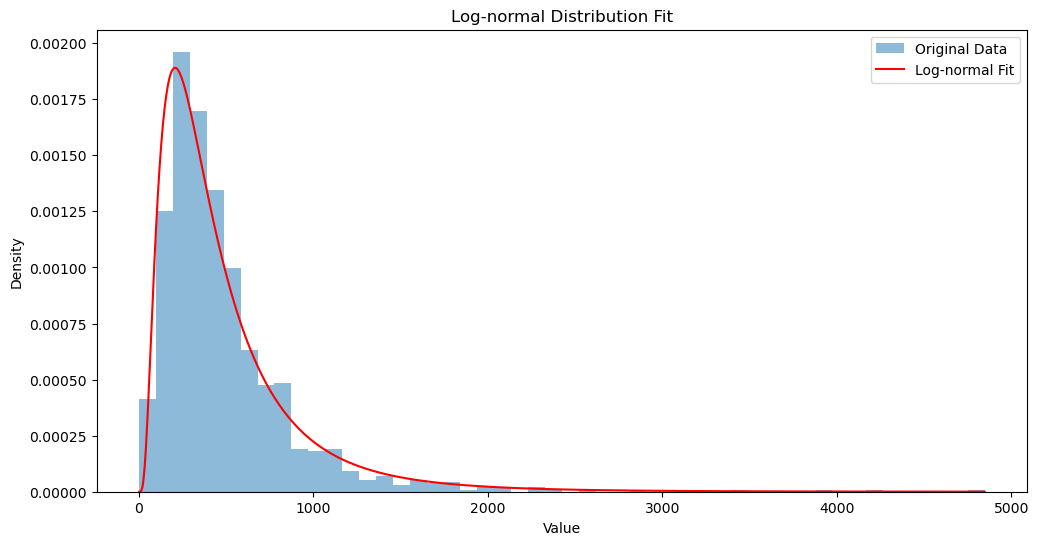

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import scanpy as sc
import scipy.sparse as sp

def calc_var(X, axis=0):
    return np.var(X, axis=axis)

def fit_lognormal(data):
    log_data = np.log(data)
    mu = np.mean(log_data)
    sigma = np.std(log_data)
    return sigma, 0, np.exp(mu)

def generate_lognormal_samples(params, n_samples):
    sigma, loc, scale = params
    return lognorm.rvs(s=sigma, loc=loc, scale=scale, size=n_samples)

def plot_distribution(data, params):
    plt.figure(figsize=(12, 6))
    
    # 绘制原始数据直方图
    plt.hist(data, bins=50, density=True, alpha=0.5, label='Original Data')
    
    # 生成用于绘制的x值
    x = np.linspace(min(data), max(data), 1000)
    
    # 绘制对数正态分布曲线
    sigma, loc, scale = params
    y_lognorm = lognorm.pdf(x, s=sigma, scale=scale)
    plt.plot(x, y_lognorm, 'r-', label='Log-normal Fit')
    
    plt.legend()
    plt.title('Log-normal Distribution Fit')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()

# 读取数据
adata = sc.read("/Users/chen_yiru/Desktop/simulation/data/raw/merfish_adata.h5ad")
# 如果adata.X是稀疏矩阵，请转换为密集矩阵
if sp.issparse(adata.X):
    adata.X = adata.X.A
# 计算基因方差
gene_variances = calc_var(adata.X)

# 拟合对数正态分布
lognormal_params = fit_lognormal(gene_variances)

# 生成样本
lognormal_samples = generate_lognormal_samples(lognormal_params, n_samples=1000)

# 可视化对数正态分布拟合
plot_distribution(gene_variances, lognormal_params)


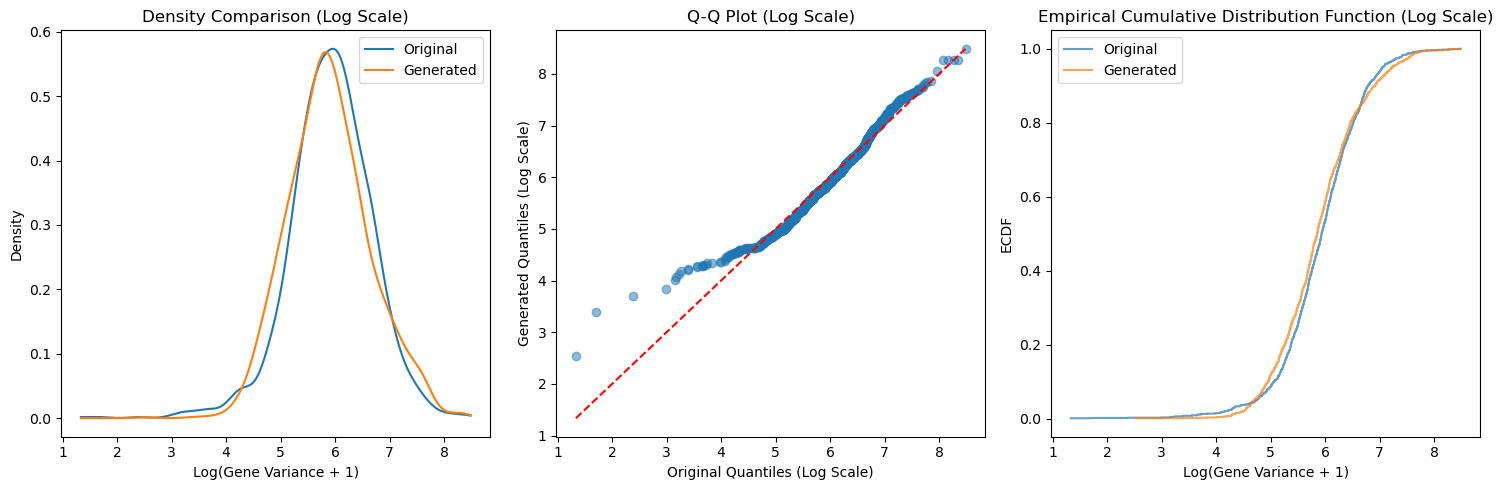

混合分布模型评估:
Cohen's d: -0.008151923410060179
Relative Error: 0.007388644180362107
KS Statistic: 0.05847953216374269
Correlation: 0.9922951634907117
Quantile Relative Errors:
  25.0th: 0.1186
  50.0th: 0.0747
  75.0th: 0.0386
  90.0th: 0.1311
  95.0th: 0.1989
  99.0th: 0.0865
Verdict: Excellent fit


In [58]:
# 生成混合分布样本
mixed_samples = generate_mixed_samples(params, n_samples=len(gene_variances))

# 评估混合分布模型
mixed_evaluation = evaluate_fit(gene_variances, mixed_samples)

# 打印结果
print("混合分布模型评估:")
for key, value in mixed_evaluation.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue:.4f}")
    else:
        print(f"{key}: {value}")